#### Libraries required to preprocess the data and perform analysis

In [1]:
import os
import pandas as pd
import numpy as np
import re
#NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

#Scikit-Learn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#Spell Correction
!pip install autocorrect
from autocorrect import Speller

#Tokenization
!pip install wordninja
import wordninja

#Necessary Libraries for plotting charts
import matplotlib.pyplot as plt
%matplotlib inline
#plotly
!pip install plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Necessary Libraries to find similarity
import math
from collections import Counter

# initializing spell checker 
spell = Speller(lang='en')

### Custom stop words list 

In [2]:
stopwordslist= ['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'into',
 'through',
 'during',
 'before',
 'after',
 'to',
 'from',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'should',
 "should've",
 'now',
 'ma']


# Data source

We have scraped data from Glassdoor for 4 different companies.
- Google
- Microsoft
- IBM
- Amazon

Code for scrapping is provided in the github link:
https://github.com/sagark93/Text-Analytics/blob/master/glassdoor_scrapping.ipynb

reference was taken from code in this github repository: https://github.com/MatthewChatham/glassdoor-review-scraper

In [8]:
# loading the data extracted form the glassdoor into a pandas dataframe
df=pd.read_csv('Final-Data.csv', engine = 'python')
df.head()

,CompanyName,AuthorEmploymentStatus,AuthorJobRole,AuthorLocation,Pros,Cons,ReviewDate,ReviewMainText,ReviewTitle,OverallRating
0,AstraZenca,Former Employee,Senior Director,"Gaithersburg, MD",Meaningful - we impact patient's lives through...,I can't think of any,18-May-20,I worked at AstraZeneca full-time for more tha...,"""Amazing place to work""",5
1,AstraZenca,Current Employee,Sales Representative,NaN,"Great products, good environment, flexible","Volatile industry, can be stressful at times",30-Aug-20,I have been working at AstraZeneca full-time f...,"""Great company""",4
2,AstraZenca,Current Employee,QA Specialist II,"Frederick, MD",Salary is good and competive,Growth in QA is slow,30-Aug-20,I have been working at AstraZeneca full-time f...,"""Growth Issues""",4
3,AstraZenca,Former Employee,Quality Assurance,NaN,Great culture. Management cared. Company funct...,It was sad to see the company being bought out.,30-Aug-20,I worked at AstraZeneca full-time,"""A great company to work for.""",5
4,AstraZenca,Former Employee,Recruitment Advisor,NaN,"Flexible remote work, flexible work hours",I do not recall any cons,26-Aug-20,I worked at AstraZeneca part-time,"""Good place to work""",4


## Clean/preprocess corpus

In [9]:
# converting all the columns name to lower case for easy access
df.columns = df.columns.str.lower()
reviews = df

In [11]:
import datetime as datetime
df.reviewdate = pd.to_datetime(df['reviewdate'])

In [12]:
df.reviewdate
df["reviewdate"]

0      2020-05-18
1      2020-08-30
2      2020-08-30
3      2020-08-30
4      2020-08-26
          ...    
7430   2010-04-02
7431   2010-02-12
7432   2010-01-02
7433   2009-10-26
7434   2008-08-15
Name: reviewdate, Length: 7435, dtype: datetime64[ns]

In [13]:
# adding year and month 

df['review_year'] = df.apply(lambda x:x['reviewdate'].year,axis=1)
df['review_month'] = df.apply(lambda x:x['reviewdate'].month,axis=1)

In [14]:
# replace null values with empty string
# as we are considering pros,cons and reviewtitle to calculate polarity, we don't want to lose data

def remove_null(text):
    text = ''
    return text

# replacing null values in pros and cons columns
for i in df[df['pros'].isnull()]['pros'].index:
    df.loc[i,'pros'] = remove_null(df.loc[i,'pros'])

for i in df[df['cons'].isnull()]['cons'].index:
    df.loc[i,'cons'] = remove_null(df.loc[i,'cons'])

In [15]:
import re
import nltk
nltk.download('averaged_perceptron_tagger')
from pycontractions import Contractions
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kulka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kulka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
import re

def contractions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# Preprocessing of text data 

lemmatizer = WordNetLemmatizer()

# function to extract extract noun, adjective, verb and adverbs from the text
# and tag pos for better lemmatization

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                 "N": wordnet.NOUN,
                 "V": wordnet.VERB,
                 "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocess(text):
     if (len(text)>0):

# contractions is a library for converting words like "I'm" to "I am"
        text=contractions(text)
        
# Removing all the special characters from the review text
     for char in '!#$%&@?,.:;+-*/=<>"\'()[\\]X{|}~\n\t1234567890':
        text = str(text).replace(char, ' ')
            
# Converting all the words in review into lower case
        text=text.lower()
        
# splitting the words in a sentence.
        word_list = wordninja.split(text)
        
# removing stopwords from customzied stopwordlists 
# and considering only word of length greater than 2
        word_list=[spell(w) for w in word_list if w not in stopwordslist and len(w) > 2]
        
# extract noun, adjective, verb and adverbs from the text and perform lemmatizton   
        lemmatized_text=' '.join(([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list]))
        return lemmatized_text
     else:
        return ''

# cleaning the pros, cons and reviewTitle
df['cleanpros'] = df['pros'].apply(lambda text: text_preprocess(text))
df['cleancons'] = df['cons'].apply(lambda text: text_preprocess(text))
df['cleantitle'] = df['reviewtitle'].apply(lambda text: text_preprocess(text))

# Combing all the clean text information given by the user
df['cleantext'] = df[['cleanpros', 'cleancons','cleantitle']].apply(lambda x: ' '.join(x), axis=1)

#### Exporting clean data file to reviewcsv1.2.csv

In [18]:
df.to_csv('C:/Users/kulka/OneDrive/Desktop/Text Analytics/reviewcsv1.2.csv')

In [19]:
# reading the clean data file into dataframe df
df=pd.read_csv('C:/Users/kulka/OneDrive/Desktop/Text Analytics/reviewcsv1.2.csv')

In [20]:
# replace null values with empty string on the clean data file
def remove_null(text):
    text = ''
    return text

#  repalcing null values in pros and cons columns
for i in df[df['cleanpros'].isnull()]['cleanpros'].index:
    df.loc[i,'cleanpros'] = remove_null(df.loc[i,'cleanpros'])

for i in df[df['cleancons'].isnull()]['cleancons'].index:
    df.loc[i,'cleancons'] = remove_null(df.loc[i,'cleancons'])

# Exploratory Data Analysis & Visualizations

### Pie plot of Ratings distribution in reviews by company

In [21]:
company_names = df.companyname.unique()
def pieplotratingsdistribution(df,companyname):
    labels = df[df['companyname']==companyname]['overallrating'].value_counts().index
    values = df[df['companyname']==companyname]['overallrating'].value_counts().values
    title = 'Ratings distribution in reviews of {}'.format(companyname)
    trace = go.Pie(labels=labels, values=values, title = title)
    py.iplot([trace], filename='basic_pie_chart')
    

for name in company_names:
    pieplotratingsdistribution(df,name)

### Stacked bar chart of employment status

In [60]:
def stackedbarplot(df):
    company_names=list(df['companyname'].unique())
    Employee_categories=list(df['authoremploymentstatus'].unique())
    print(Employee_categories)
    count_list=[]
    for j in Employee_categories:
        for i in company_names:
            count_list.append(df[(df['companyname']==i)&(df['authoremploymentstatus']==j)].shape[0])
    temp=[]
    for i in range(0, len(count_list),len(company_names)):
        temp.append(list(count_list[i:i + len(company_names)]))
    data=[] 
    k=0
    for i in Employee_categories:
        data.append(go.Bar(name=i,x=company_names,y=temp[k]))
        k=k+1
    fig = go.Figure(data=data)
# Change the bar mode
    fig.update_layout(barmode='stack')
    fig.show()

stackedbarplot(df)

['Former Employee ', 'Current Employee ', nan, '\xa0']


### Plotting Word Count distribution bar plot

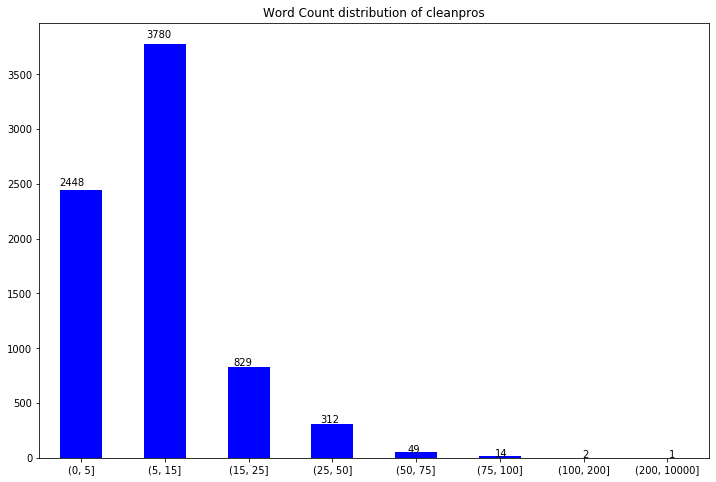

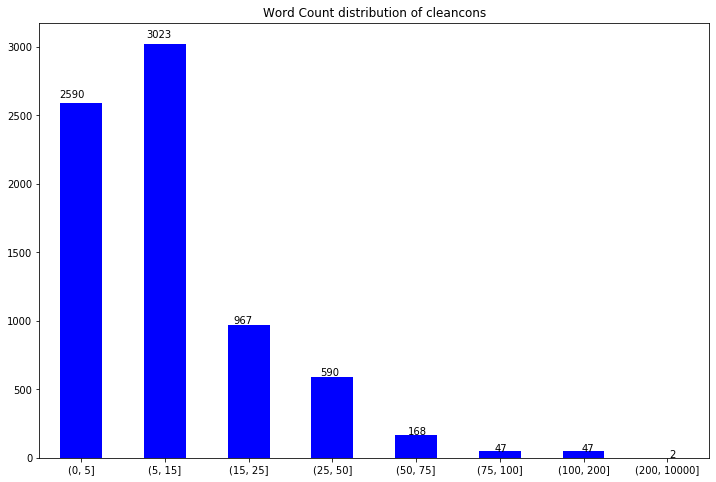

In [24]:
def plotwordcountdistribution(df,reviewtype):
    #reviewtype is 'Pros_Modified_Text','Cons_Modified_Text' in our case
    def comment_len(x):
        if type(x) is str:
            return len(x.split())
        else:
            return 0
    df['review_len'] = df[reviewtype].apply(comment_len)
    length_scale=[0,5,15,25,50,75,100,200,10000]#Change length scale according to your requirement
    out = pd.cut(df['review_len'],length_scale)
    ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,8))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.040, p.get_height() * 1.015))
    plt.title('Word Count distribution of {}'.format(reviewtype))
    plt.show()
    df.drop(columns=['review_len'])
    
plotwordcountdistribution(df,'cleanpros')
plotwordcountdistribution(df,'cleancons')

## Text analysis (Sentiment score analysis)



In [26]:
# Perform sentiment analysis on cleantext
import nltk
nltk.download('vader_lexicon')
analyzer=SentimentIntensityAnalyzer()
def polarity_score(text):
    if len(text)>0:
        score=analyzer.polarity_scores(text)['compound']
        return score
    else:
        return 0
df['polarityscore'] =df['cleantext'].apply(lambda text : polarity_score(text))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kulka\AppData\Roaming\nltk_data...


### Sentiment score anomalies bar plot

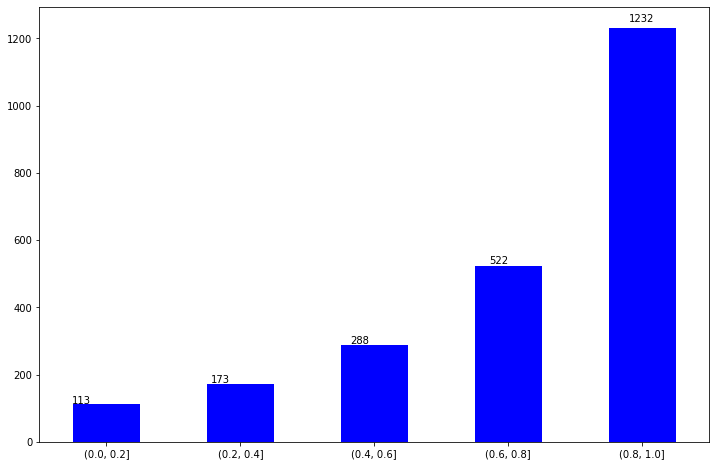

In [27]:
def sentianamolybarplot(df):
    polarity_scale=[0.0,0.2,0.4,0.6,0.8,1]
    #'Review_polarity' is column name of sentiment score calculated for whole review.
    df2=df[(df['polarityscore']>0)&(df['overallrating']<=3)]
    out = pd.cut(df2['polarityscore'],polarity_scale)
    ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,8))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.040, p.get_height() * 1.015))
    plt.show()
sentianamolybarplot(df)

### Distribution of polarity score

In [28]:
def polarityscorehistplot(df,companyname):
#     df['Review_polarity'] = df['Pros'].map(lambda text: TextBlob(text).sentiment.polarity)
    fig = px.histogram(df, x='polarityscore')
    fig.update_layout(title_text='Distribution of sentiment polarity in Reviews {}'.format(companyname), template="plotly_white")
    fig.show()

for name in company_names:
    polarityscorehistplot(df,name)

## Text vectorization

### Defining n trigrams

In [29]:
def top_n_trigram(corpus):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

### Defining n bigrams

In [30]:
def top_n_bigram(corpus):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

### Extracting trigrams from clean pros and cons text

In [31]:
company_names = df.companyname.unique()

dict_trigrams_pros= {}
dict_trigrams_cons= {}

for name in company_names:
    dict_trigrams_pros[name] = top_n_trigram(df[df['companyname']==name]['cleanpros'])

for name in company_names:
    dict_trigrams_cons[name] = top_n_trigram(df[df['companyname']==name]['cleancons'])

### Bar plot of top 20 trigrams 

In [32]:
def bar_plot_toptrigrams(trigrams, reviewtype = 'Pros'):
    for companyname in trigrams:
        common_words = trigrams[name][:20]
        df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
        fig = px.bar(df1, x='word', y='count')
        fig.update_layout(title_text= '{0} Review Tri-gram count top 20 for {1}'.format(reviewtype, companyname), template="plotly_white")
        fig.show()

bar_plot_toptrigrams(dict_trigrams_pros)
bar_plot_toptrigrams(dict_trigrams_cons,'Cons') 

### Extracting Bigrams from clean pros and cons text

In [33]:
dict_bigrams_pros= {}
dict_bigrams_cons= {}

for name in company_names:
    dict_bigrams_pros[name] = top_n_bigram(df[df['companyname']==name]['cleanpros'])

for name in company_names:
    dict_bigrams_cons[name] = top_n_bigram(df[df['companyname']==name]['cleancons']) 

### Bar plot of top 20 Bigrams 

In [34]:
def bar_plot_topbigrams(bigrams, reviewtype = 'Pros'):
    for companyname in bigrams:
        common_words = bigrams[name][:20]
        df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
        fig = px.bar(df1, x='word', y='count')
        fig.update_layout(title_text= '{0} Review Bi-gram count top 20 for {1}'.format(reviewtype, companyname), template="plotly_white")
        fig.show()

bar_plot_topbigrams(dict_bigrams_pros)
bar_plot_topbigrams(dict_bigrams_cons,'Cons')    

#### number of negative trigrams

In [35]:
for key in dict_trigrams_cons:
    print(key,len(dict_trigrams_cons[key]))

AstraZenca 21937
Roche 16190
Novartis 13182
Boehringer Ingelheim 13476


####  number of postive trigrams

In [36]:
for key in dict_trigrams_pros:
    print(key,len(dict_trigrams_pros[key]))

AstraZenca 15460
Roche 11427
Novartis 9040
Boehringer Ingelheim 7907


## Text analysis to find best and worst features for each company

### Function to find similarity between two trigrams and bigrams

In [37]:
def cosine_similarity_grams(a, b):
    vec1 = Counter(a)
    vec2 = Counter(b)

    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    return float(numerator) / denominator
# Ref : https://gist.github.com/gaulinmp/da5825de975ed0ea6a24186434c24fe4

### Function to find a list of unique grams and find grams which are similar to unique grams

In [38]:
# create of list of 100 trigrams for each company
def check_similarity(dict_grams):
    top_grams = {}
    for key in dict_grams:
#         consider top 100 grams for each comapny
        top_100 = dict_grams[key][:100]
        top_similar = {}
        top = []
        for i in top_100:
            for j,val in enumerate(top_100):
#    check similarity between two grams
                if cosine_similarity_grams(i[0],val[0]) > 0.65:
#     calculate total freq of similar words
                    freq = i[1] + val[1]
#     collect all the simialr gram in a list
                    if i[0] not in top_similar:
                        top_similar[i[0]] = []
                    top_similar[i[0]].append(val[0])
#    delete grams which is simialar 
                    del top_100[j]
            top.append((i[0],freq))
#       collect all the top grams into a dictionary 
        top_grams[key] = top
#       collect all the similar grams 
        top_grams[str(key)+str('_similar')] = top_similar
    return top_grams

### Extracting top trigrams and similar trigrams for pros and cons

In [39]:
top_pros_trigrams = check_similarity(dict_trigrams_pros)
top_cons_trigrams = check_similarity(dict_trigrams_cons)

### Extracting top bigrams and similar trigrams for pros and cons

In [40]:
top_pros_bigrams = check_similarity(dict_bigrams_pros)
top_cons_bigrams = check_similarity(dict_bigrams_cons)

### Find the average sentiment score of unique grams and sort by average sentiment score

In [41]:
# sort the kewyword list 
def sortlist(keywords_list):
    keywords_list =sorted(keywords_list, key = lambda x: x[2], reverse=True)
    return keywords_list

# find the average polarity of unique grams
def avgpolarity(name, trigrams, col='cleancons'):
    grp = df[df['companyname'] == name]
    lst = []
    for keyword in  trigrams[name]:
#         print(keyword[0] ,grp.loc[grp['cleanpros'].str.contains(keyword[0])]['polarityscore'].mean())
        lst.append((keyword[0],keyword[1],grp.loc[grp[col].str.contains(keyword[0])]['polarityscore'].mean()))
#     print(sortlist(lst))
    return sortlist(lst)

#### Calculate average sentiment score for bigrams and trigrams of cons

In [42]:
top5_cons_bigrams = {}
top5_cons_trigrams = {}
for name in company_names:
    top5_cons_bigrams[name] = avgpolarity(name,top_cons_bigrams)
    top5_cons_trigrams[name] = avgpolarity(name,top_cons_trigrams)

#### Calculate average sentiment score for bigrams and trigrams of pros

In [43]:
top5_pros_bigrams = {}
top5_pros_trigrams = {}
for name in company_names:
    top5_pros_bigrams[name] = avgpolarity(name,top_pros_bigrams,'cleanpros')
    top5_pros_trigrams[name] = avgpolarity(name,top_pros_trigrams,'cleanpros')

### Printing top bigrams in pros with frequency and average polarity

In [45]:
top5_pros_bigrams

{'AstraZenca': [('growth opportunity', 28, 0.86404375),
  ('great people', 84, 0.8285861111111112),
  ('happy hour', 30, 0.8232933333333333),
  ('good benefit', 144, 0.8120772727272729),
  ('work environment', 106, 0.8052489361702125),
  ('salary benefit', 55, 0.7623069767441861),
  ('work life', 273, 0.7502494208494213),
  ('fast pace', 29, 0.7356214285714288),
  ('med immune', 42, 0.7329166666666665),
  ('good pay', 79, 0.7167640625000002),
  ('company car', 41, 0.6113500000000001),
  ('cut edge', 24, 0.4868166666666667)],
 'Roche': [('culture good', 50, 0.9005823529411763),
  ('lot opportunity', 46, 0.8658428571428572),
  ('great company', 100, 0.8607428571428573),
  ('roche great', 36, 0.8375555555555555),
  ('benefit salary', 36, 0.8312099999999999),
  ('good work', 152, 0.7990895522388058),
  ('high quality', 40, 0.79163),
  ('good benefit', 250, 0.7831008547008544),
  ('work life', 270, 0.7787196850393706),
  ('pay benefit', 60, 0.7464681818181816)],
 'Novartis': [('ovaritis gre

### Printing top bigrams in cons with frequency and average polarity

In [46]:
top5_cons_bigrams

{'AstraZenca': [('could well', 19, 0.9240444444444444),
  ('not always', 33, 0.8306541666666666),
  ('high level', 18, 0.8108333333333332),
  ('lot change', 28, 0.7649473684210527),
  ('development opportunity', 23, 0.7358266666666665),
  ('career progression', 26, 0.7283399999999999),
  ('service base', 18, 0.7233714285714286),
  ('big company', 26, 0.7167764705882353),
  ('med immune', 49, 0.7075000000000001),
  ('not good', 41, 0.6967548387096774),
  ('work life', 110, 0.649829),
  ('astray zen', 68, 0.6217018867924529),
  ('home office', 18, 0.6184875),
  ('big harm', 39, 0.5035105263157896),
  ('cost cut', 20, 0.40256)],
 'Roche': [('people not', 28, 0.9213142857142856),
  ('many process', 28, 0.8875857142857144),
  ('work environment', 44, 0.8844333333333335),
  ('management seem', 28, 0.86955),
  ('hard get', 42, 0.8390769230769229),
  ('way much', 24, 0.8340333333333332),
  ('not always', 60, 0.8177),
  ('hard work', 36, 0.8099384615384616),
  ('slow move', 40, 0.80220833333333

### Printing top Trigrams in cons with frequency and average polarity

In [47]:
top5_cons_trigrams

{'AstraZenca': [('long work hour', 5, 0.8860666666666667),
  ('inexperienced people high', 4, 0.80455),
  ('second class citizen', 5, 0.7763333333333334),
  ('get thing do', 13, 0.7724999999999999),
  ('work life balance', 100, 0.6550663265306124),
  ('life balance work', 6, 0.6474500000000001),
  ('not many opportunity', 9, 0.4577428571428572),
  ('manager not great', 4, 0.43470000000000003)],
 'Roche': [('keep employee grow', 8, 0.9720500000000001),
  ('old boy club', 12, 0.9107333333333333),
  ('not lot room', 8, 0.8987),
  ('nil nil nil', 12, 0.891),
  ('limited growth opportunity', 10, 0.8836666666666667),
  ('management not transparent', 10, 0.8782666666666668),
  ('work life balance', 84, 0.7330224999999998),
  ('many lay offs', 8, 0.6286),
  ('upper management not', 14, 0.5668400000000001),
  ('may dumped lap', 8, 0.4268),
  ('decision make process', 18, 0.3656142857142858)],
 'Novartis': [('politics politics politics', 6, 0.9287),
  ('micro manage work', 4, 0.9204),
  ('not mu

### Printing top Trigrams in pros with frequency and average polarity

In [48]:
top5_pros_trigrams

{'AstraZenca': [('good place work', 23, 0.791921052631579),
  ('good benefit package', 14, 0.77775),
  ('astray zen era', 71, 0.7763099999999998),
  ('good work environment', 20, 0.772375),
  ('work life balance', 257, 0.7475163346613549),
  ('benefit great people', 11, 0.6485666666666666)],
 'Roche': [('good compensation benefit', 14, 0.9163749999999999),
  ('life balance great', 18, 0.9035500000000001),
  ('great work environment', 44, 0.8701684210526315),
  ('good company good', 16, 0.8589800000000001),
  ('work life balance', 248, 0.7784917355371905),
  ('benefit work life', 28, 0.6678272727272726)],
 'Novartis': [('great benefit great', 9, 0.9572833333333334),
  ('good compensation package', 7, 0.9061),
  ('work life balance', 113, 0.7799418181818183),
  ('lot smart people', 6, 0.7361999999999999),
  ('great company work', 20, 0.6679764705882354),
  ('good company work', 11, 0.64715),
  ('flexible work schedule', 13, 0.37725)],
 'Boehringer Ingelheim': [('blah blah blah', 6, 0.967

#### Similar words in top trigrams (pros)

In [49]:
for name in company_names:
    print(name)
    print(top_pros_trigrams[str(name) +'_similar'])

AstraZenca
{'work life balance': ['work life balance', 'good work life', 'great work life', 'good salary benefit', 'great company work', 'good pay benefit', 'great benefit good', 'flexible work arrangement', 'benefit work life', 'great work environment', 'flexible work hour', 'flexible work schedule', 'benefit flexible work', 'benefit good pay', 'salary good benefit', 'take care employee', 'life work balance', 'best place work', 'great benefit pay', 'place work lot', 'company great benefit', 'life balance benefit', 'good benefit great', 'zen era great', 'life balance flexible', 'life balance free', 'salary benefit good', 'people great work', 'company treat employee', 'benefit good people', 'good place learn', 'life balance career', 'company work life', 'benefit package good', 'free food cab', 'competitive salary benefit', 'great employee benefit', 'benefit company car', 'christmas new year', 'life balance excellent', 'good life work'], 'astray zen era': ['great place work', 'life balan

#### Similar words in top trigrams (cons)

In [50]:
for name in company_names:
    print(name)
    print(top_cons_trigrams[str(name) +'_similar'])

AstraZenca
{'work life balance': ['work life balance', 'great place work', 'slow decision make', 'work astray zen', 'zen era not', 'life balance not', 'not care employee', 'below industry average', 'decision make slow', 'not really con', 'management work life', 'not always clear', 'good work life', 'good place work', 'career advancement opportunity', 'full time employee', 'life balance difficult', 'large pharmaceutical company', 'life balance challenge', 'place ever work', 'open floor plan', 'life balance non', 'not value employee', 'slow make change', 'down decision make', 'large company come', 'place work not', 'like big harm', 'management skill not', 'promote unless manager', 'work home policy', 'work evening weekend', 'layoff every year', 'management change low', 'people work silo', 'lot conference call', 'leave company result', 'day per week'], 'get thing do': ['get thing do', 'difficult get promote', 'hard get promote', 'get work do', 'move gait burg', 'difficult get thing', 'mid

#### Similar words in top bigrams (pros)

In [51]:
for name in company_names:
    print(name)
    print(top_pros_bigrams[str(name) +'_similar'])

AstraZenca
{'work life': ['work life', 'place work', 'flexible work', 'great work', 'people work', 'work great', 'work home', 'work culture', 'free food', 'benefit work', 'flexible hour', 'team work', 'work schedule', 'follow science'], 'good benefit': ['good benefit', 'great benefit', 'benefit good', 'good people', 'benefit great', 'benefit package', 'development opportunity', 'balance good', 'employee benefit', 'environment good', 'good training', 'compensation benefit', 'good opportunity', 'good compensation', 'good environment', 'friendly environment', 'benefit pay', 'environment great'], 'work environment': ['work environment', 'company work', 'opportunity learn', 'opportunity work', 'career development', 'learn new', 'career opportunity', 'learn opportunity', 'fitness center'], 'great people': ['great place', 'zen era', 'great company', 'good place', 'great culture', 'great product', 'great pay', 'people good', 'care employee', 'excellent benefit', 'good pipeline', 'smart people'

#### Similar words in top bigrams (cons)

In [52]:
for name in company_names:
    print(name)
    print(top_cons_bigrams[str(name) +'_similar'])

AstraZenca
{'work life': ['work life', 'place work', 'work home', 'people work', 'senior leader', 'feel like', 'not like'], 'astray zen': ['astray zen', 'senior management', 'management not', 'large company', 'constant change', 'management team', 'manager not', 'career advancement', 'base company', 'not care', 'many layer', 'past year', 'senior manager', 'line manager'], 'med immune': ['med immune', 'upper management', 'middle management', 'many employee'], 'not good': ['not good', 'not enough', 'company not', 'not know', 'lot work', 'long hour', 'not work', 'not promote', 'not get', 'not lot', 'work not', 'would not'], 'not always': ['not always', 'not many', 'not value', 'not want'], 'big harm': ['micro manage', 'gait burg'], 'lot change': ['life balance', 'not much', 'hard get', 'poor management', 'long term', 'thing do', 'many change', 'get thing', 'change not', 'nothing much', 'not make'], 'big company': ['big company', 'harm company', 'company work', 'leave company'], 'career pro

# Dashboard in Tableau

https://public.tableau.com/profile/sagar.surendra.kulkarni#!/vizhome/Text_Analytics_Updated/Dashboard1